In [1]:
import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")


All done


In [2]:
Path_data = './re_eye_dataset'
data = os.listdir(Path_data)
Healthy = os.listdir('./re_eye_dataset/Healthy')
Mild = os.listdir('./re_eye_dataset/Mild DR')
Moderate = os.listdir('./re_eye_dataset/Moderate DR')
Proliferate = os.listdir('./re_eye_dataset/Proliferate DR')
Severe = os.listdir('./re_eye_dataset/Severe DR')

In [3]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

classes names : ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



In [4]:
import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Get Paths
Path_data = './re_eye_dataset'

# Create two lists to store paths of images and their labels
imgpaths = []
labels = []

# Convert directory to list
data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data
for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)

    for img in imglist:
        imgpath = os.path.join(classpath, img)

        imgpaths.append(imgpath)
        labels.append(i)

# Convert two lists of imgpaths and their labels into series
Paths = pd.Series(imgpaths, name='Paths')
Labels = pd.Series(labels, name='Labels')

# Concatenate them in one Dataframe called Tr_data
Df = pd.concat([Paths, Labels], axis=1)
Df.head(10)


,Paths,Labels
0,./re_eye_dataset\Healthy\Healthy.png,Healthy
1,./re_eye_dataset\Healthy\Healthy_10.png,Healthy
2,./re_eye_dataset\Healthy\Healthy_100.png,Healthy
3,./re_eye_dataset\Healthy\Healthy_1000.png,Healthy
4,./re_eye_dataset\Healthy\Healthy_101.png,Healthy
5,./re_eye_dataset\Healthy\Healthy_102.png,Healthy
6,./re_eye_dataset\Healthy\Healthy_103.png,Healthy
7,./re_eye_dataset\Healthy\Healthy_104.png,Healthy
8,./re_eye_dataset\Healthy\Healthy_105.png,Healthy
9,./re_eye_dataset\Healthy\Healthy_106.png,Healthy


In [5]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


Labels
Healthy           805
Moderate DR       723
Mild DR           291
Proliferate DR    230
Severe DR         151
Name: count, dtype: int64

In [6]:
batch_size = 20   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


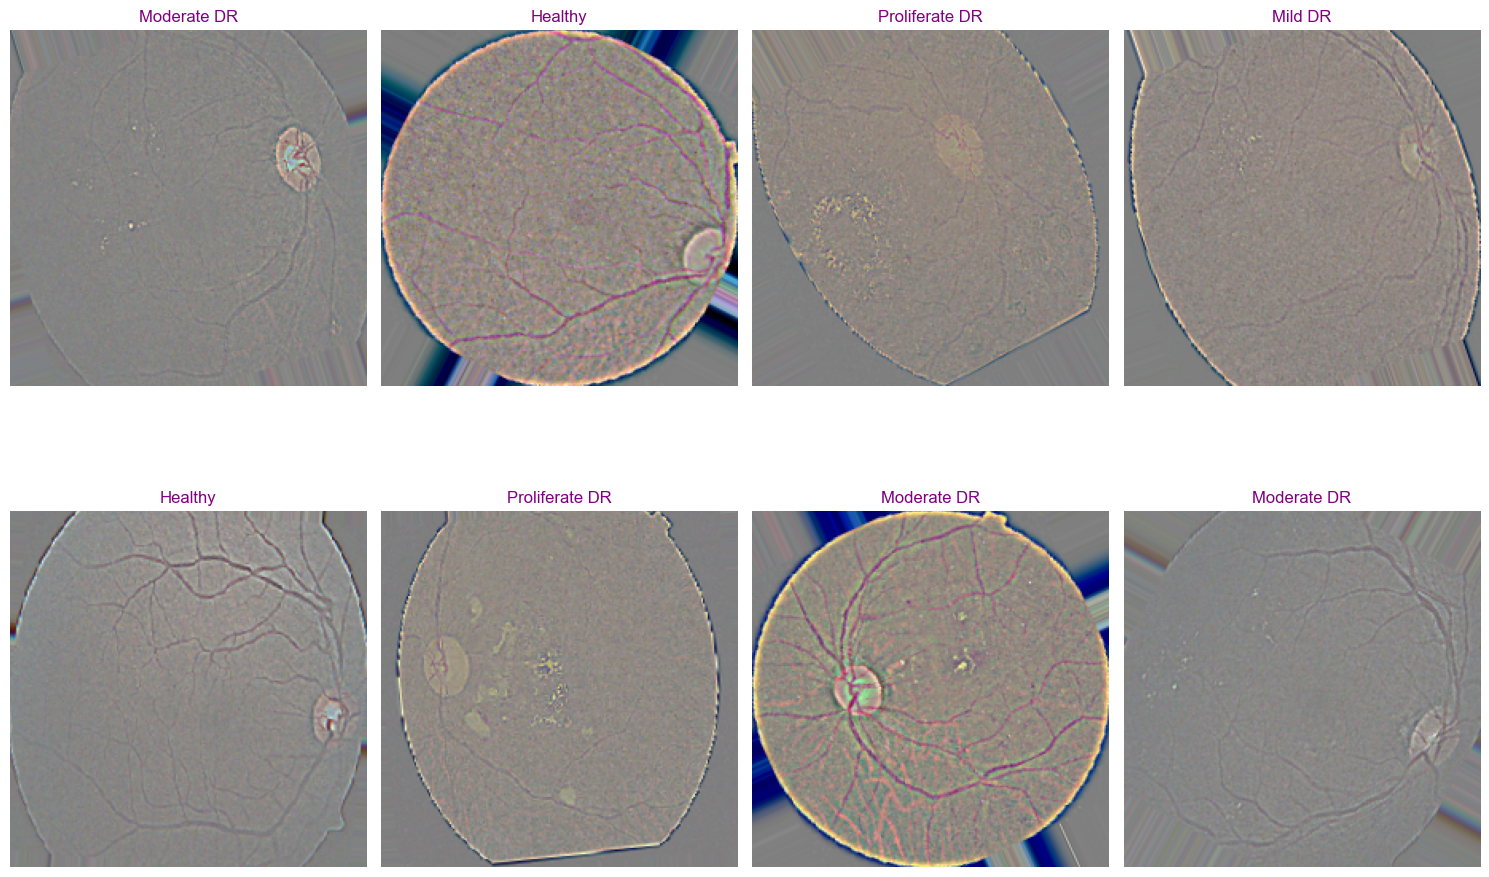

In [7]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

Epoch 46/50
110/110 [==============================] - 84s 761ms/step - loss: 0.5798 - accuracy: 0.8000 - val_loss: 0.5789 - val_accuracy: 0.8000
Epoch 47/50
110/110 [==============================] - 85s 765ms/step - loss: 0.5780 - accuracy: 0.8000 - val_loss: 0.5771 - val_accuracy: 0.8000
Epoch 48/50
110/110 [==============================] - 83s 747ms/step - loss: 0.5762 - accuracy: 0.8000 - val_loss: 0.5753 - val_accuracy: 0.8000
Epoch 49/50
110/110 [==============================] - 83s 751ms/step - loss: 0.5745 - accuracy: 0.8000 - val_loss: 0.5736 - val_accuracy: 0.8000
Epoch 50/50
110/110 [==============================] - 83s 756ms/step - loss: 0.5727 - accuracy: 0.8000 - val_loss: 0.5719 - val_accuracy: 0.8000


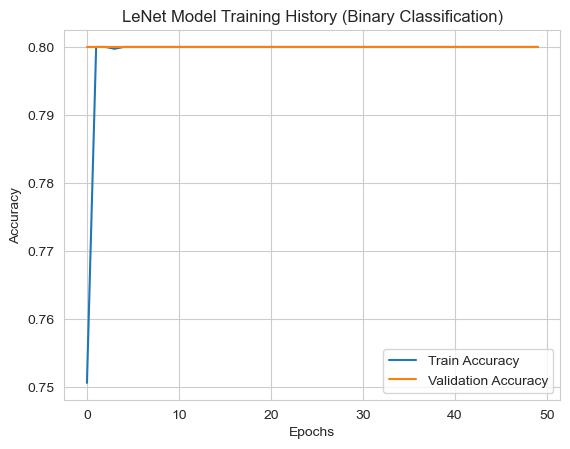

14/14 [==============================] - 2s 152ms/step - loss: 0.5719 - accuracy: 0.8000
Test Accuracy (Binary Classification): 0.800000011920929


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Assuming img_shape is defined earlier
# Assuming Train, Valid, and Test datasets are loaded and preprocessed

# LeNet Model for Binary Classification (0 and 1)
lenet_model_binary = Sequential()

# First Convolutional Layer
lenet_model_binary.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=img_shape))
lenet_model_binary.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
lenet_model_binary.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
lenet_model_binary.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
lenet_model_binary.add(Flatten())

# Fully Connected Layers
lenet_model_binary.add(Dense(128, activation='relu'))
lenet_model_binary.add(Dropout(0.5))  # Adding dropout for regularization
lenet_model_binary.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
lenet_model_binary.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
lenet_model_binary.summary()

# Train the model
lenet_epochs_binary = 50
lenet_history_binary = lenet_model_binary.fit(
    Train,
    epochs=lenet_epochs_binary,
    validation_data=Valid,
    shuffle=True
)

# Plot training history
plt.plot(lenet_history_binary.history['accuracy'], label='Train Accuracy')
plt.plot(lenet_history_binary.history['val_accuracy'], label='Validation Accuracy')
plt.title('LeNet Model Training History (Binary Classification)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on the test set
test_loss_binary, test_accuracy_binary = lenet_model_binary.evaluate(Test)
print(f'Test Accuracy (Binary Classification): {test_accuracy_binary}')


In [9]:
# ...

# Evaluate on the test set
test_loss_binary, test_accuracy_binary = lenet_model_binary.evaluate(Test)
print(f'Test Accuracy (Binary Classification): {test_accuracy_binary}')

# Predictions on the test set
y_pred_binary = lenet_model_binary.predict(Test)
y_pred_binary = (y_pred_binary > 0.5).astype(int)  # Convert probabilities to binary predictions

# True labels
y_true_binary = Test.labels

# Confusion matrix
conf_matrix_binary = confusion_matrix(y_true_binary, y_pred_binary)

# Print the confusion matrix
print('Confusion Matrix (Binary Classification):')
print(conf_matrix_binary)


14/14 [==============================] - 2s 136ms/step - loss: 0.5719 - accuracy: 0.8000
Test Accuracy (Binary Classification): 0.800000011920929
14/14 [==============================] - 2s 137ms/step
Confusion Matrix (Binary Classification):
[[ 92   0   0   0   0]
 [ 41   0   0   0   0]
 [100   0   0   0   0]
 [ 23   0   0   0   0]
 [ 19   0   0   0   0]]


In [10]:
# ...

# Confusion matrix
conf_matrix_binary = confusion_matrix(y_true_binary, y_pred_binary)

# Print the confusion matrix in box format
print('Confusion Matrix (Binary Classification):')
print(f'True Negative: {conf_matrix_binary[0, 0]} | False Positive: {conf_matrix_binary[0, 1]}')
print(f'False Negative: {conf_matrix_binary[1, 0]} | True Positive: {conf_matrix_binary[1, 1]}')

# ...


Confusion Matrix (Binary Classification):
True Negative: 92 | False Positive: 0
False Negative: 41 | True Positive: 0


14/14 [==============================] - 2s 127ms/step


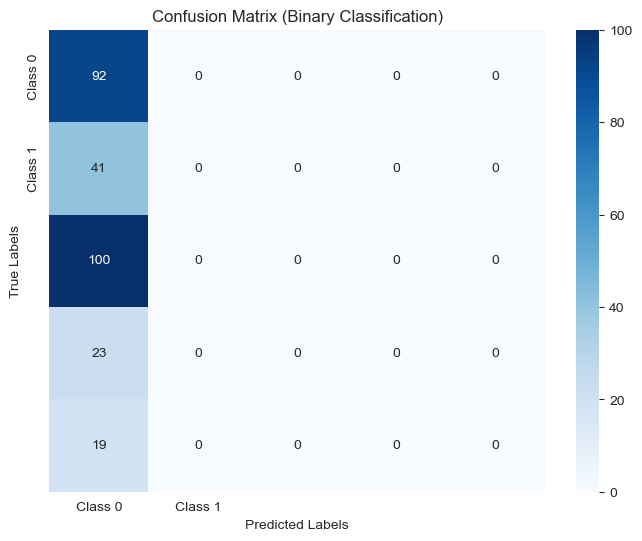

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming img_shape is defined earlier
# Assuming Test dataset is loaded and preprocessed

# Get predictions on the test set
predictions = lenet_model_binary.predict(Test)

# Convert predictions to class labels
predicted_labels = (predictions > 0.5).astype(int)

# Convert generator labels to array
true_labels = Test.labels

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix (Binary Classification)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 373248)            0         
                                                                 
 dense_2 (Dense)             (None, 512)              

110/110 [==============================] - 394s 4s/step - loss: 0.8925 - accuracy: 0.6632 - val_loss: 0.9747 - val_accuracy: 0.6873
Epoch 45/50
110/110 [==============================] - 393s 4s/step - loss: 0.8779 - accuracy: 0.6705 - val_loss: 1.0465 - val_accuracy: 0.6727
Epoch 46/50
110/110 [==============================] - 396s 4s/step - loss: 0.8874 - accuracy: 0.6659 - val_loss: 1.2541 - val_accuracy: 0.6291
Epoch 47/50
110/110 [==============================] - 396s 4s/step - loss: 0.9029 - accuracy: 0.6577 - val_loss: 0.9524 - val_accuracy: 0.6618
Epoch 48/50
110/110 [==============================] - 395s 4s/step - loss: 0.8551 - accuracy: 0.6732 - val_loss: 0.9481 - val_accuracy: 0.6800
Epoch 49/50
110/110 [==============================] - 400s 4s/step - loss: 0.8721 - accuracy: 0.6764 - val_loss: 0.8974 - val_accuracy: 0.6800
Epoch 50/50
110/110 [==============================] - 407s 4s/step - loss: 0.8764 - accuracy: 0.6764 - val_loss: 0.9226 - val_accuracy: 0.6618


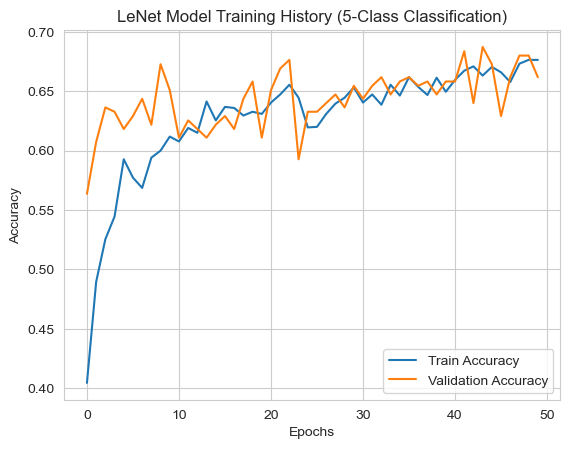

14/14 [==============================] - 8s 587ms/step - loss: 0.9333 - accuracy: 0.6473
Test Accuracy (5-Class Classification): 0.6472727060317993


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming img_shape is defined earlier
# Assuming Train, Valid, and Test datasets are loaded and preprocessed

# LeNet Model for 5-Class Classification
lenet_model_5class = Sequential()

# First Convolutional Layer
lenet_model_5class.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=img_shape))
lenet_model_5class.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
lenet_model_5class.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
lenet_model_5class.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
lenet_model_5class.add(Flatten())

# Fully Connected Layers
lenet_model_5class.add(Dense(512, activation='relu'))
lenet_model_5class.add(Dropout(0.5))

# Additional Dense Layer
lenet_model_5class.add(Dense(256, activation='relu'))
lenet_model_5class.add(Dropout(0.5))

# Output layer for 5-class classification
lenet_model_5class.add(Dense(5, activation='softmax'))

# Adjusted Learning Rate
lenet_model_5class.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
lenet_model_5class.summary()

lenet_epochs_5class = 50
lenet_history_5class = lenet_model_5class.fit(
    Train,
    epochs=lenet_epochs_5class,
    validation_data=Valid,
    shuffle=True
)

# Plot training history
plt.plot(lenet_history_5class.history['accuracy'], label='Train Accuracy')
plt.plot(lenet_history_5class.history['val_accuracy'], label='Validation Accuracy')
plt.title('LeNet Model Training History (5-Class Classification)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on the test set
test_loss_5class, test_accuracy_5class = lenet_model_5class.evaluate(Test)
print(f'Test Accuracy (5-Class Classification): {test_accuracy_5class}')


14/14 [==============================] - 7s 490ms/step


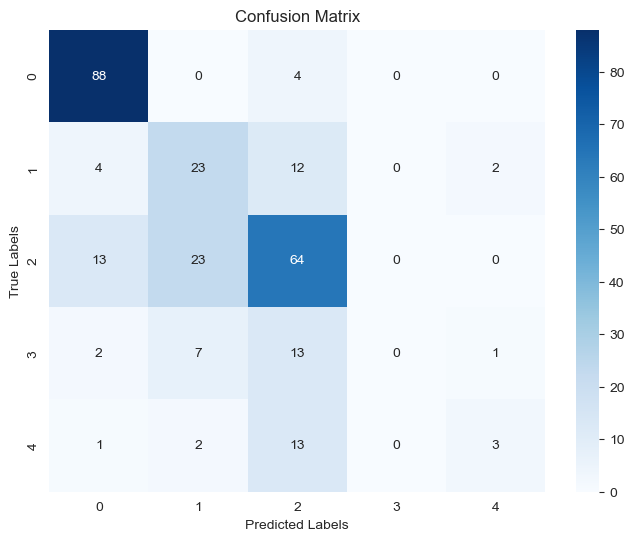

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions on the test set
predictions = lenet_model_5class.predict(Test)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert generator labels to array
true_labels = Test.classes

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Assuming class_names is a list containing the names of your classes
class_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5']

# Get predictions on the test set for LeNet
predictions_lenet = lenet_model_binary.predict(Test)
predicted_labels_lenet = np.round(predictions_lenet)

# Convert generator labels (class names) to array as strings
true_labels_lenet = [class_names[idx] for idx in Test.classes]

# Convert predicted labels to integers and then to strings
predicted_labels_lenet = [class_names[int(label)] for label in predicted_labels_lenet.astype(int)]

# Generate confusion matrix for LeNet
conf_matrix_lenet = confusion_matrix(true_labels_lenet, predicted_labels_lenet, labels=class_names)
print("Confusion Matrix (LeNet):")
print(conf_matrix_lenet)

# Generate classification report for LeNet
class_report_lenet = classification_report(true_labels_lenet, predicted_labels_lenet, target_names=class_names)
print("Classification Report (LeNet):")
print(class_report_lenet)


14/14 [==============================] - 3s 191ms/step
Confusion Matrix (LeNet):
[[ 92   0   0   0   0]
 [ 41   0   0   0   0]
 [100   0   0   0   0]
 [ 23   0   0   0   0]
 [ 19   0   0   0   0]]
Classification Report (LeNet):
              precision    recall  f1-score   support

      Class1       0.33      1.00      0.50        92
      Class2       0.00      0.00      0.00        41
      Class3       0.00      0.00      0.00       100
      Class4       0.00      0.00      0.00        23
      Class5       0.00      0.00      0.00        19

    accuracy                           0.33       275
   macro avg       0.07      0.20      0.10       275
weighted avg       0.11      0.33      0.17       275



In [22]:
import wget

# URL for InceptionV3 weights file
inception_weights_url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Destination path to save the downloaded file
weights_path = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Download the file
wget.download(inception_weights_url, weights_path)

print(f'Downloaded InceptionV3 weights to {weights_path}')


Downloaded InceptionV3 weights to inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
# Get predictions on the test set for InceptionV3
predictions_inception = inception_model.predict(Test)
predicted_labels_inception = np.argmax(predictions_inception, axis=1)

# Convert generator labels (class names) to array as strings
true_labels_inception = [str(class_names[idx]) for idx in Test.classes]

# Generate confusion matrix for InceptionV3
conf_matrix_inception = confusion_matrix(true_labels_inception, predicted_labels_inception)
print("Confusion Matrix (InceptionV3):")
print(conf_matrix_inception)

# Generate classification report for InceptionV3
class_report_inception = classification_report(true_labels_inception, predicted_labels_inception, target_names=class_names)
print("Classification Report (InceptionV3):")
print(class_report_inception)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Assuming img_shape is defined earlier
# Assuming Train, Valid, and Test datasets are loaded and preprocessed

# ResNet Model for 5-class Classification
resnet_model = Sequential()

# Use the ResNet50 base model (pre-trained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

resnet_model.add(base_model)

# Add GlobalAveragePooling2D layer and fully connected layers
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(5, activation='softmax'))  # Output layer for 5-class classification

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
resnet_model.summary()

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(Train)

# Train the model with data augmentation
resnet_epochs = 50
resnet_history = resnet_model.fit(
    datagen.flow(Train, ..., batch_size=32),
    epochs=resnet_epochs,
    validation_data=Valid,
    shuffle=True
)

# Plot training history
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on the test set
test_loss_resnet, test_accuracy_resnet = resnet_model.evaluate(Test)
print(f'Test Accuracy (ResNet): {test_accuracy_resnet}')


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions on the test set for ResNet
predictions_resnet = resnet_model.predict(Test)
predicted_labels_resnet = np.argmax(predictions_resnet, axis=1)

# Convert generator labels (class names) to array as strings
true_labels_resnet = [str(class_names[idx]) for idx in Test.classes]

# Generate confusion matrix for ResNet
conf_matrix_resnet = confusion_matrix(true_labels_resnet, predicted_labels_resnet)
print("Confusion Matrix (ResNet):")
print(conf_matrix_resnet)

# Generate classification report for ResNet
class_report_resnet = classification_report(true_labels_resnet, predicted_labels_resnet, target_names=class_names)
print("Classification Report (ResNet):")
print(class_report_resnet)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to generate confusion matrix and classification report
def generate_metrics(model, test_generator, class_names):
    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = [str(class_names[idx]) for idx in test_generator.classes]

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Generate classification report
    class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

    return conf_matrix, class_report

# Compare LeNet, InceptionV3, and ResNet
models = [lenet_model, inception_model, resnet_model]
model_names = ['LeNet', 'InceptionV3', 'ResNet']

conf_matrices = []
class_reports = []

for model, name in zip(models, model_names):
    conf_matrix, class_report = generate_metrics(model, Test, class_names)
    conf_matrices.append(conf_matrix)
    class_reports.append(class_report)

# Display confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, conf_matrix, name in zip(axes, conf_matrices, model_names):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
plt.show()

# Display classification reports
for class_report, name in zip(class_reports, model_names):
    print(f'Classification Report - {name}:\n{class_report}\n')

# Bar chart for accuracy comparison
accuracy_values = [model.evaluate(Test)[1] for model in models]
plt.bar(model_names, accuracy_values, color=['blue', 'green', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()
